In [1]:
# Imports
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt

# Make sure you have pytorch installed
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

# Make sure you place L96_model in the same folder as the notebook! 
from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

In [2]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

In [3]:
# L96 parameters
time_steps = 20000
forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32. This is the full coupled model
W = L96(8, 32, F=forcing)

In [4]:
# The effect of Y on X is `xy_true` (C_k term)
X_true, _, _, xy_true = W.run(dt, T, store=True, return_coupling=True)

# Change the data type to `float32` in order to avoid doing type conversions later on
X_true, xy_true = X_true.astype(np.float32), xy_true.astype(np.float32)

In [5]:
# Number of time steps for validation
val_size = 4000

# Training Data split
X_true_train = X_true[:-val_size, :]  # Flatten because we first use single input as a sample
subgrid_tend_train = xy_true[:-val_size, :]

# Test Data split (his test set is my idea of a validation set)
X_true_test = X_true[-val_size:, :]
subgrid_tend_test = xy_true[-val_size:, :]

In [6]:
# Number of sample in each batch
# You can play with this number if you are having memory issues
BATCH_SIZE = 2000

In [7]:
# Create torch datasets and dataloader. This is done through the "Data" object from pytorch
local_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_train, -1)), # Matrix is now a 1D vector size (n,)
    torch.from_numpy(np.reshape(subgrid_tend_train, -1)), # Pairing input & target
)

local_loader = Data.DataLoader( # Wraps an iterable around the dataset
    dataset=local_dataset, batch_size=BATCH_SIZE, shuffle=True # No data augm., but shuffling
)

In [8]:
# Create torch test datasets and dataloader.
local_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_test, -1)),
    torch.from_numpy(np.reshape(subgrid_tend_test, -1)),
)

local_loader_test = Data.DataLoader(
    dataset=local_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

X (State):
 tensor([ 4.1728, -1.5047,  8.8898,  ...,  5.4477, -4.0861,  0.3179])

Y (Subgrid Tendency):
 tensor([-6.7729,  0.4764, -7.8355,  ..., -5.4671, -0.0774, -1.0472])


(-12.0, 16.0)

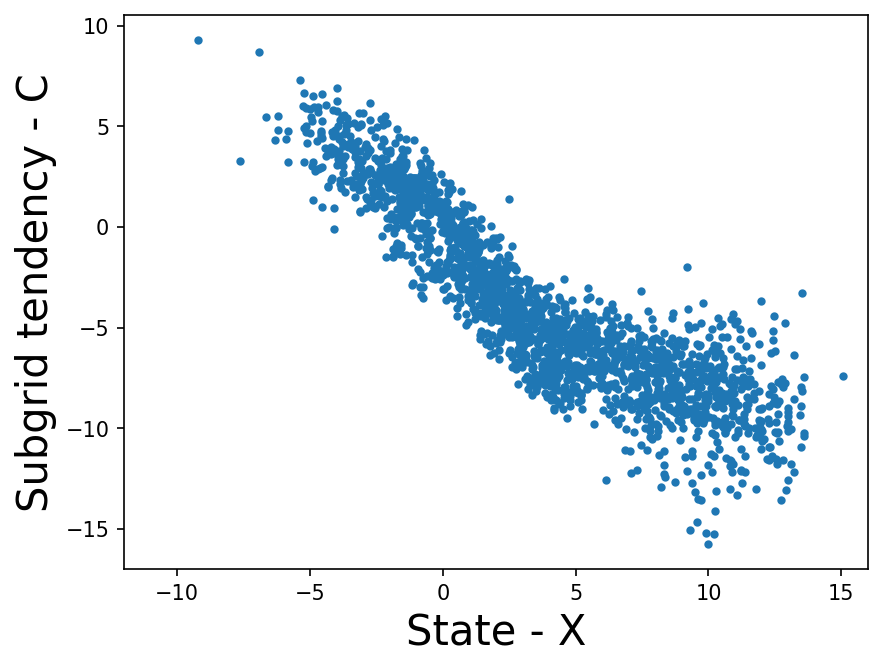

In [9]:
# Data visualization example (vizualization of the truth dataset)
# Iterating over the data to get one batch
data_iterator = iter(local_loader)
X_iter, subgrid_tend_iter = next(data_iterator) # Rappel: subgrid_tend_iter is xy_true is C_k term

print("X (State):\n", X_iter)
print("\nY (Subgrid Tendency):\n", subgrid_tend_iter)

plt.figure(dpi=150)
plt.plot(X_iter, subgrid_tend_iter, ".")
plt.xlabel("State - X", fontsize=20)
plt.ylabel("Subgrid tendency - C", fontsize=20)
plt.xlim([-12, 16])

### Architecture du modèle linéaire simple à une dimension

In [ ]:
# Simple regression model
class LinearRegression(nn.Module): # LinearRegression hérite de nn.Module
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 1)  # A single input and a single output (modèle à une seule couche). 

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.linear1(x)
        return x

# On va devoir faire un entraînement avec cette unique couche et sur toutes les batch pour obtenir la relation linéaire  
# https://stackoverflow.com/questions/64054961/what-does-pytorchs-nn-linearx-y-return
# https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-model
# Pythorch's layers list: https://docs.pytorch.org/docs/stable/nn.html 
# Pytorch's nn.Linear: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

In [ ]:
# Instanciation du modèle. On crée un objet linear_network contenant la couche (linear1) et ses poids
linear_network = LinearRegression()
linear_network # Inspection (affiche les paramètres du modèle)

LinearRegression(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
)

### Architecture du réseau de neurones simple à une dimension

In [15]:
# Simple Neural Network
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)  # 1 inputs
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 1)  # 1 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [16]:
nn_network = NN()
nn_network

NN(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [17]:
# Tests sur les deux modèles avec un input aléatoire
net_input = torch.randn(1, 1)
out_linear = linear_network(net_input)
out_nn = nn_network(net_input)
print(f"The output of the random input from the linear network is: {out_linear.item():.4f}")
print(f"The output of the random input from the nn is: {out_nn.item():.4f}")

The output of the random input from the linear network is: 1.1384
The output of the random input from the nn is: -0.1207


In [18]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

In [19]:
# Load an input and output pair from the data loader
X_tmp = next(iter(local_loader)) # Temporary, 1 iter. X_tmp[0] is X_true, X_tmp[1] is subgrid_tend (C_k term)

# Predict the output
y_tmp_linear = linear_network(torch.unsqueeze(X_tmp[0], 1)) # Y pas pour variables rapides mais pour C_k
y_tmp_nn = nn_network(torch.unsqueeze(X_tmp[0], 1))

# Calculate the MSE loss
loss_linear = loss_fn(y_tmp_linear, torch.unsqueeze(X_tmp[1], 1))
print(f"Linear network MSE Loss: {loss_linear.item():.4f}")

loss_nn = loss_fn(y_tmp_nn, torch.unsqueeze(X_tmp[1], 1))
print(f"NN MSE Loss: {loss_nn.item():.4f}")

Linear network MSE Loss: 8.7137
NN MSE Loss: 45.2517


In [20]:
learning_rate = 0.003

In [25]:
# Montrer l'ajustement des poids sur le modèle linéaire simple
optimizer_linear = optim.Adam(linear_network.parameters(), lr=learning_rate) 
print("Before backward pass (weights): \n", list(linear_network.parameters())[0].data.numpy()) # Couche d'entrée et ses poids
print("Before backward pass (biases): \n", list(linear_network.parameters())[1].data.numpy())

loss_linear.backward(retain_graph=True)
optimizer_linear.step()

print("\nAfter backward pass: \n", list(linear_network.parameters())[0].data.numpy())

# https://www.geeksforgeeks.org/deep-learning/adam-optimizer/
# Pythorch's Adam: https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
# Matlab's sgdm: https://www.mathworks.com/help/deeplearning/ref/trainingoptions.html#bu59f0q_sep_mw_6dcd8e56-4de5-497d-a48e-0f6f804f57f6_head

Before backward pass (weights): 
 [[-0.7128844]]
Before backward pass (biases): 
 [0.65495694]

After backward pass: 
 [[-0.71588445]]


In [26]:
optimizer_nn = optim.Adam(nn_network.parameters(), lr=learning_rate)

In [27]:
def train_model(network, criterion, loader, optimizer): # Criterion = loss function, Loader = data loader
    """Train the network for one epoch"""
    network.train()

    train_loss = 0
    for batch_x, batch_y in loader:
        # Get predictions
        if len(batch_x.shape) == 1:
            # This if block is needed to add a dummy dimension if our inputs are 1D
            # (where each number is a different sample)
            # On a nn.Linear(in_features, out_features) mais PyTorch attend aussi un batch de ces entrées, 
            # donc (batch_size, in_features) -> (batch_size, 1)
            prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
        else:
            prediction = network(batch_x)

        # Compute the loss
        loss = criterion(prediction, batch_y)
        train_loss += loss.item()

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute the gradients and update the weights
        loss.backward()
        optimizer.step() # Gradient Descent

    return train_loss / len(loader) # Perte moyenne pour une époque

In [29]:
def test_model(network, criterion, loader):
    """Test the network"""
    network.eval()  # Evaluation mode (important when having dropout layers) ??

    test_loss = 0
    with torch.no_grad(): # Aucun calcul de gradient -> pas d'optimisation
        for batch_x, batch_y in loader:
            # Get predictions
            if len(batch_x.shape) == 1:
                # This if block is needed to add a dummy dimension if our inputs are 1D
                # (where each number is a different sample)
                prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
            else:
                prediction = network(batch_x)

            # Compute the loss
            loss = criterion(prediction, batch_y)
            test_loss += loss.item()

        # No weights updating because test set

        # Get an average loss for the entire dataset
        test_loss /= len(loader)

    return test_loss

# Validation (test) set: doesn't adjust model parameters/hyperparameters
# "A validation [test] dataset is a sample of data held back from training your model that is 
# used to give an estimate of model skill while tuning model’s hyperparameters."
# "The evaluation of a model skill on the training dataset would result in a biased score"
# Source: https://machinelearningmastery.com/difference-test-validation-dataset/

In [30]:
def fit_model(network, criterion, optimizer, train_loader, test_loader, n_epochs):
    """Train and validate the network"""
    train_losses, test_losses = [], []
    for epoch in range(1, n_epochs + 1):
        train_loss = train_model(network, criterion, train_loader, optimizer)
        test_loss = test_model(network, criterion, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    print("Training complete!")
    return train_losses, test_losses

In [31]:
# Epochs refer to the number of times we iterate over the entire training data during training.
n_epochs = 25

In [32]:
# Training the linear model
train_loss_linear, test_loss_linear = fit_model(
    linear_network, loss_fn, optimizer_linear, local_loader, local_loader_test, n_epochs
)

Training complete!


In [33]:
# Training the 1D NN model
train_loss_nn, test_loss_nn = fit_model(
    nn_network, loss_fn, optimizer_nn, local_loader, local_loader_test, n_epochs
)

Training complete!


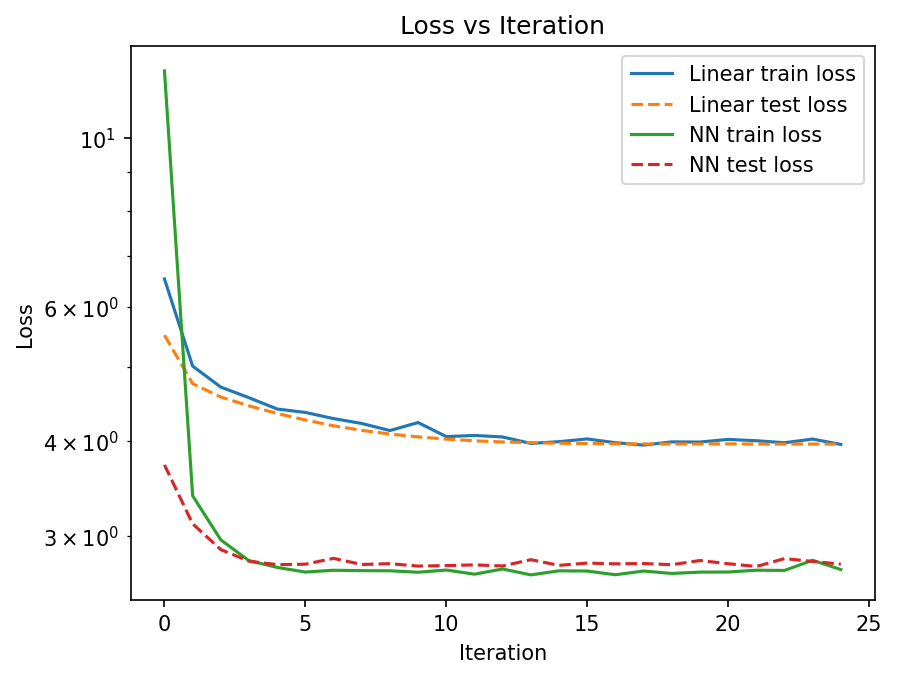

In [34]:
plt.figure(dpi=150)

plt.plot(train_loss_linear, label="Linear train loss")
plt.plot(test_loss_linear, linestyle="--", label="Linear test loss")

plt.plot(train_loss_nn, label="NN train loss")
plt.plot(test_loss_nn, linestyle="--", label="NN test loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();


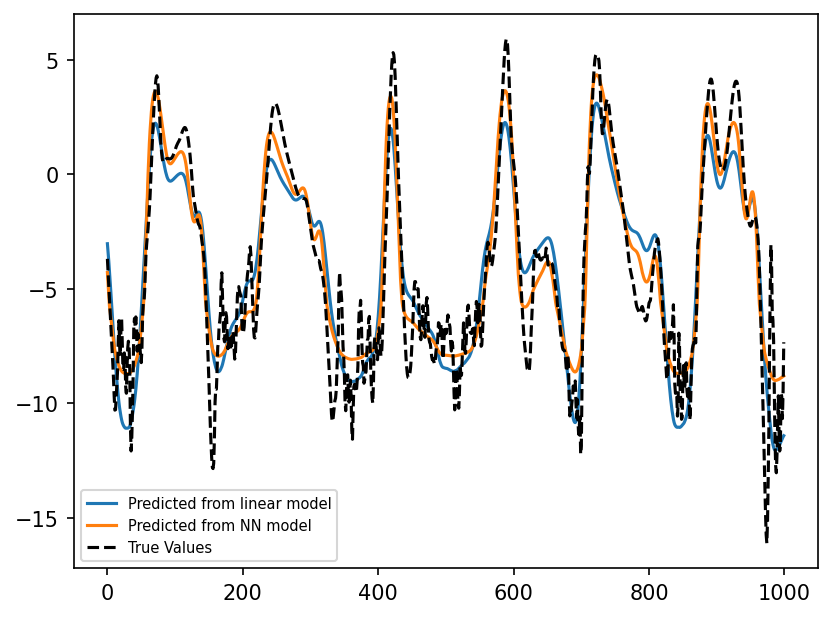

In [ ]:
# Faire des prédictions avec nos modèles entraînés (on reprend le test set)
predictions_linear = linear_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1) # Prédictions des C_k pour tout les X de test
)
predictions_nn = nn_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1)
)


plt.figure(dpi=150)
plt.plot(
    predictions_linear.detach().numpy()[0:1000], label="Predicted from linear model"
)
plt.plot(predictions_nn.detach().numpy()[0:1000], label="Predicted from NN model")
plt.plot(subgrid_tend_test[:1000, 1], label="True Values", color="k", linestyle="--")
plt.legend(fontsize=7);

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/T_predict_low.png',dpi=500)

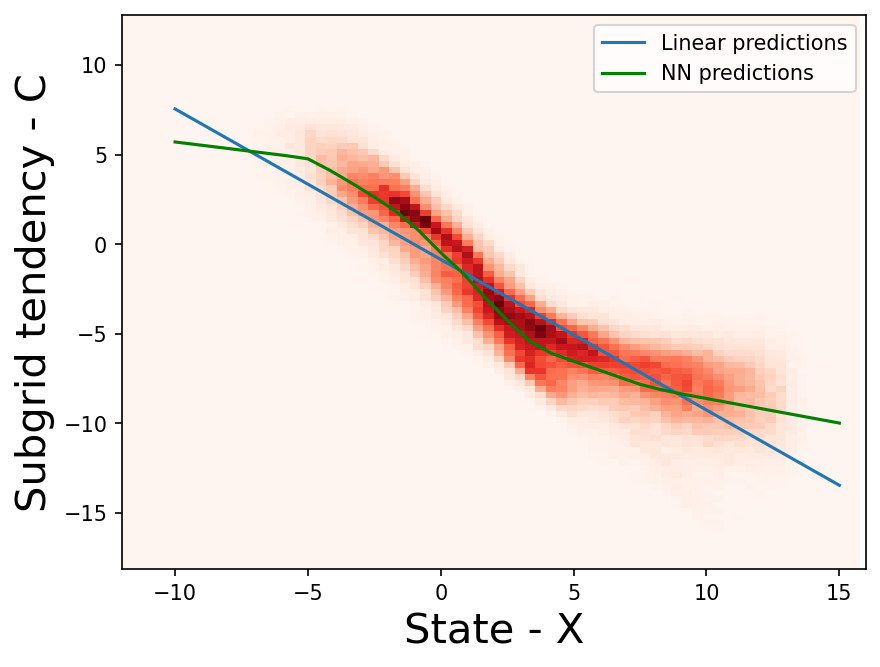

In [ ]:
X_points = torch.from_numpy(np.linspace(-10, 15, 31).astype(np.float32)) # On crée notre série de X

linear_pred = linear_network(torch.unsqueeze(X_points, 1)).detach().numpy() # Prédictions

nn_pred = nn_network(torch.unsqueeze(X_points, 1)).detach().numpy()


plt.figure(dpi=150)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds") # Histo 2D!

plt.plot(X_points, linear_pred, "-", label="Linear predictions")
plt.plot(X_points, nn_pred, "-", label="NN predictions", color="g")

plt.legend()
plt.xlim([-12, 16])
plt.xlabel("State - X", fontsize=20)
plt.ylabel("Subgrid tendency - C", fontsize=20);

In [29]:
# Now lets look at a nonlocal model...

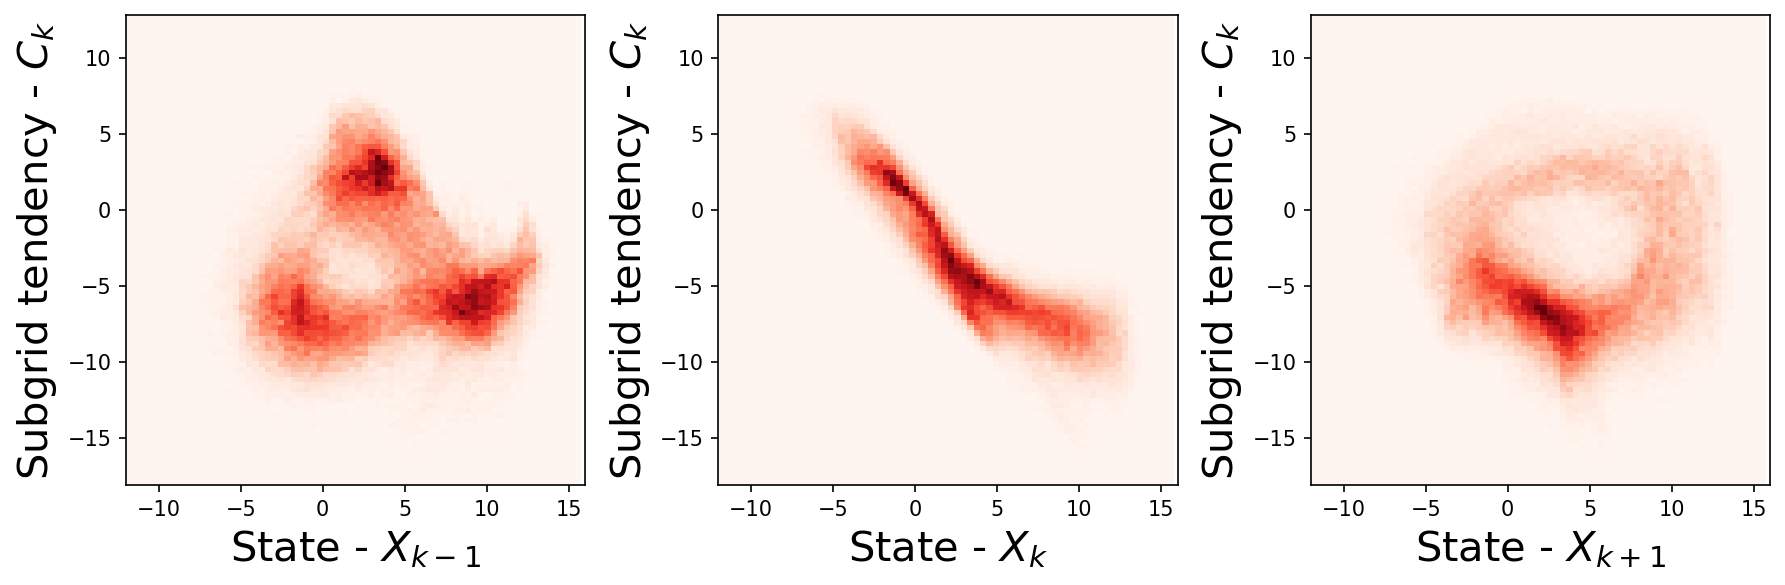

In [30]:
plt.figure(figsize=(12, 4), dpi=150)

plt.subplot(131)
plt.hist2d(
    np.reshape(np.roll(X_true, -1, axis=1), -1),
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k-1}$", fontsize=20)
plt.ylabel("Subgrid tendency - $C_{k}$", fontsize=20)

plt.subplot(132)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds")
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k}$", fontsize=20)
plt.ylabel("Subgrid tendency - $C_{k}$", fontsize=20)

plt.subplot(133)
plt.hist2d(
    np.reshape(np.roll(X_true, 1, axis=1), -1),
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k+1}$", fontsize=20)
plt.ylabel("Subgrid tendency - $C_{k}$", fontsize=20)

plt.tight_layout()

In [31]:
# Training Dataset
# ----------------
nlocal_data_train = Data.TensorDataset(
    torch.from_numpy(X_true_train),
    torch.from_numpy(subgrid_tend_train),
)
nlocal_loader_train = Data.DataLoader(
    dataset=nlocal_data_train, batch_size=BATCH_SIZE, shuffle=True
)


# Test Dataset
# ------------
nlocal_data_test = Data.TensorDataset(
    torch.from_numpy(X_true_test), torch.from_numpy(subgrid_tend_test)
)
nlocal_loader_test = Data.DataLoader(
    dataset=nlocal_data_test, batch_size=BATCH_SIZE, shuffle=True
)

### Architecture du réseau de neurones simple à huit dimension

In [ ]:
class NonLocal_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [33]:
nonlocal_nn_network = NonLocal_NN()

In [34]:
optimizer_nonlocal_nn = optim.Adam(
    nonlocal_nn_network.parameters(), lr=learning_rate
)

In [35]:
n_epochs = 120
train_loss_nonlocal, test_loss_nonlocal = fit_model(
    nonlocal_nn_network,
    loss_fn,
    optimizer_nonlocal_nn,
    nlocal_loader_train,
    nlocal_loader_test,
    n_epochs,
)

Training complete!


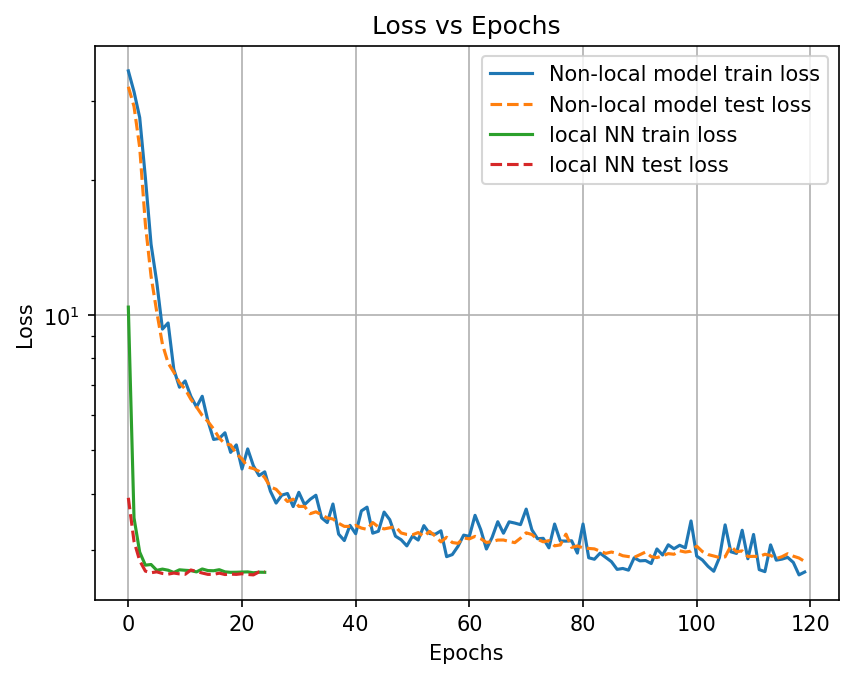

In [36]:
plt.figure(dpi=150)

plt.plot(train_loss_nonlocal, label="Non-local model train loss")
plt.plot(test_loss_nonlocal, linestyle="--", label="Non-local model test loss")

plt.plot(train_loss_nn, label="local NN train loss")
plt.plot(test_loss_nn, linestyle="--", label="local NN test loss")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.grid()
plt.show();

In [37]:
# Save the trained networks
save_path = "non_local_NN.pth"
torch.save(nonlocal_nn_network.state_dict(), save_path)

save_path = "local_NN.pth"
torch.save(nn_network.state_dict(), save_path)

save_path = "linear.pth"
torch.save(linear_network.state_dict(), save_path)